In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch.nn.functional as F
import torch
from torch import nn, autograd
from torch.utils.data import DataLoader, Dataset
import numpy as np
import copy
import random
from sklearn import metrics
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import copy

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
def process_data(train, test, lags):
    """Process data
    Reshape and split train/test data.

    # Arguments
        train: String, name of .csv train file.
        test: String, name of .csv test file.
        lags: integer, time lag.
    # Returns
        X_train: ndarray.
        y_train: ndarray.
        X_test: ndarray.
        y_test: ndarray.
        scaler: StandardScaler.
    """
    attr = 'Lane 1 Flow (Veh/5 Minutes)'
    df1 = pd.read_csv(train, encoding='utf-8').fillna(0)
    df2 = pd.read_csv(test, encoding='utf-8').fillna(0)

    # print(df1)
    # print(df2)

    # scaler = StandardScaler().fit(df1[attr].values)
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(df1[attr].values.reshape(-1, 1))
    flow1 = scaler.transform(df1[attr].values.reshape(-1, 1)).reshape(1, -1)[0]
    flow2 = scaler.transform(df2[attr].values.reshape(-1, 1)).reshape(1, -1)[0]

    # plt.plot(flow1[:3000])

    # print(flow1)
    # print(flow2)

    train, test = [], []
    for i in range(lags, len(flow1)):
        train.append(flow1[i - lags: i + 1])
    for i in range(lags, len(flow2)):
        test.append(flow2[i - lags: i + 1])

    train = np.array(train)
    test = np.array(test)
    
    # print(train, test)

    np.random.shuffle(train)

    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = test[:, :-1]
    y_test = test[:, -1]

    return X_train, y_train, X_test, y_test, scaler

In [3]:
process_data('/home/girikk/FedGRU/data/train.csv', '/home/girikk/FedGRU/data/test.csv', 12)

(array([[0.08629442, 0.06091371, 0.1319797 , ..., 0.26903553, 0.30964467,
         0.34010152],
        [0.22335025, 0.20304569, 0.26903553, ..., 0.37055838, 0.53807107,
         0.51269036],
        [0.34517766, 0.30964467, 0.35532995, ..., 0.37563452, 0.29949239,
         0.35532995],
        ...,
        [0.31979695, 0.44162437, 0.38071066, ..., 0.37055838, 0.30964467,
         0.34517766],
        [0.03045685, 0.05076142, 0.02538071, ..., 0.00507614, 0.01015228,
         0.02538071],
        [0.2893401 , 0.3248731 , 0.32994924, ..., 0.65482234, 0.52791878,
         0.68020305]]),
 array([0.34010152, 0.47715736, 0.27411168, ..., 0.35532995, 0.01522843,
        0.7106599 ]),
 array([[0.08121827, 0.05076142, 0.05583756, ..., 0.03553299, 0.02030457,
         0.03553299],
        [0.05076142, 0.05583756, 0.05583756, ..., 0.02030457, 0.03553299,
         0.06091371],
        [0.05583756, 0.05583756, 0.03045685, ..., 0.03553299, 0.06091371,
         0.02538071],
        ...,
        [0.14

In [4]:
def iid(dataset, num_users):
    num_items = int(len(dataset) / num_users)
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items, replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users

In [5]:
import torch.nn.functional as F

class GRU(nn.Module):
    def __init__(self, input_num, hidden_num, output_num, num_layers=1):
        """
        GRU (Gated Recurrent Unit) model implementation.

        Args:
            input_num (int): Number of input features.
            hidden_num (int): Number of units in the hidden state.
            output_num (int): Number of output features.
            num_layers (int): Number of GRU layers (default is 1).

        Attributes:
            hidden_size (int): Number of units in the hidden state.
            num_layers (int): Number of GRU layers.
            GRU_layers (nn.ModuleList): List of GRU layers.
            output_linear (nn.Linear): Output linear layer.
            hidden (list): List to store hidden state for each layer.
        """
        super(GRU, self).__init__()
        self.hidden_size = hidden_num
        self.num_layers = num_layers
        
        # Define the GRU layers
        self.GRU_layers = nn.ModuleList([
            nn.GRU(input_size=input_num if i == 0 else hidden_num,
                   hidden_size=hidden_num,
                   batch_first=True) for i in range(num_layers)
        ])
        
        # Output linear layer
        self.output_linear = nn.Linear(hidden_num, output_num)
        
        # Initialize hidden state for each layer
        self.hidden = None

    def forward(self, x):
        """
        Forward pass through the GRU model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, input_size).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, sequence_length, output_size).
            list: List of hidden states for each layer.
        """
        # Initialize hidden state for each layer
        self.hidden = [None] * self.num_layers
        
        # Reshape input tensor
        x = x.view(x.shape[0], -1, x.shape[1]).float()
        
        # Forward pass through each GRU layer
        for i in range(self.num_layers):
            x, self.hidden[i] = self.GRU_layers[i](x, self.hidden[i])
            x = F.relu(x)  # Apply ReLU activation function
        
        # Pass through output linear layer
        x = self.output_linear(x)
        
        return x, self.hidden


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class DatasetSplit(Dataset):
    def __init__(self, dataset, indices):
        """
        Custom dataset class for data splitting.

        Args:
            dataset (Dataset): Original dataset.
            indices (list): List of indices to select data samples from the original dataset.
        """
        self.dataset = dataset
        self.indices = list(indices)

    def __len__(self):
        """
        Return the number of samples in the dataset.

        Returns:
            int: Number of samples.
        """
        return len(self.indices)

    def __getitem__(self, idx):
        """
        Retrieve a data sample and its corresponding label from the dataset.

        Args:
            idx (int): Index of the data sample to retrieve.

        Returns:
            tuple: Tuple containing the data sample and its corresponding label.
        """
        image, label = self.dataset[self.indices[idx]]
        return image, label

class LocalUpdate(object):
    def __init__(self, args, dataset=None, indices=None):
        """
        Local update class for training a model on a subset of data.

        Args:
            args (object): Object containing training arguments.
            dataset (Dataset): Dataset object containing the training data.
            indices (list): List of indices to select training samples from the dataset.
        """
        self.args = args
        self.loss_func = nn.L1Loss()
        self.selected_clients = []
        self.data_loader = DataLoader(DatasetSplit(dataset, indices), 
                                      batch_size=self.args['local_bs'], 
                                      shuffle=True)

    def train(self, model):
        """
        Train the model on the local dataset.

        Args:
            model (nn.Module): PyTorch model to be trained.

        Returns:
            dict: State dictionary of the trained model.
            float: Average loss over the training epoch.
        """
        model.train()
        optimizer = torch.optim.SGD(model.parameters(), lr=self.args['lr'], momentum=self.args['momentum'])
        epoch_loss = []

        for epoch in range(self.args['epochs']):
            batch_loss = []

            for batch_idx, (images, labels) in enumerate(self.data_loader):
                images, labels = images.to(self.args['gpu']), labels.to(self.args['gpu'])
                optimizer.zero_grad()
                outputs, _ = model(images)
                outputs = outputs.reshape(outputs.shape[0])
                loss = self.loss_func(outputs, labels)
                loss.backward()
                optimizer.step()

                if self.args['verbose'] and batch_idx % 10 == 0:
                    print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(images), len(self.data_loader.dataset),
                        100. * batch_idx / len(self.data_loader), loss.item()))

                batch_loss.append(loss.item())

            epoch_loss.append(sum(batch_loss) / len(batch_loss))

        return model.state_dict(), sum(epoch_loss) / len(epoch_loss)


In [7]:
import copy
import torch

def federated_average(weights):
    """
    Perform Federated Averaging to aggregate model weights from multiple clients.

    This function takes a list of model weights dictionaries from individual clients
    and computes the element-wise average to produce a global model weight dictionary.

    Args:
        weights (list of dict): List containing model weights dictionaries from clients.

    Returns:
        dict: Global model weights dictionary after aggregation.
    """
    # Initialize the average weights with a deep copy of the first client's weights
    average_weights = copy.deepcopy(weights[0])

    # Iterate over each key in the weights dictionary
    for key in average_weights.keys():
        # Sum up the corresponding parameter tensors from all clients (excluding the first client)
        for i in range(1, len(weights)):
            average_weights[key] += weights[i][key]

        # Compute the average by dividing the sum by the number of clients
        average_weights[key] = torch.div(average_weights[key], len(weights))

    return average_weights

### MODEL TRAINING

In [8]:
args = {
    'epochs': 20,
    'num_users': 2,
    'frac': 0.1,
    'local_ep': 5,
    'local_bs': 10,
    'bs': 128,
    'lr': 0.01,
    'momentum': 0.5,
    'split': 'user',
    'model': 'gru',
    'norm': 'batch_norm',
    'dataset': 'tf',
    'iid': False,
    'num_classes': 10,
    'gpu': 0,
    'stopping_rounds': 10,
    'verbose': False,
    'seed': 69,
    'all_clients': False
}


In [9]:
lag = 12
file1 = 'data/train.csv'
file2 = 'data/test.csv'
X_train, y_train, X_test, y_test, _ = process_data(file1, file2, lag)
X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), \
                                    torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()
dataset_train = TensorDataset(X_train, y_train)
dataset_test = TensorDataset(X_test, y_test)
dict_users = iid(dataset_train, args['num_users'])

In [10]:
input_num, hidden_num, output_num, n_layers = 12, 50, 1, 1
net_glob = GRU(input_num, hidden_num, output_num, n_layers).to(args['gpu'])

In [11]:
print(net_glob)
net_glob.train()

GRU(
  (GRU_layers): ModuleList(
    (0): GRU(12, 50, batch_first=True)
  )
  (output_linear): Linear(in_features=50, out_features=1, bias=True)
)


GRU(
  (GRU_layers): ModuleList(
    (0): GRU(12, 50, batch_first=True)
  )
  (output_linear): Linear(in_features=50, out_features=1, bias=True)
)

Round   0, Average loss 0.044
Round   1, Average loss 0.038
Round   2, Average loss 0.037
Round   3, Average loss 0.037
Round   4, Average loss 0.037
Round   5, Average loss 0.036
Round   6, Average loss 0.037
Round   7, Average loss 0.037
Round   8, Average loss 0.037
Round   9, Average loss 0.037
Round  10, Average loss 0.037
Round  11, Average loss 0.037
Round  12, Average loss 0.037
Round  13, Average loss 0.036
Round  14, Average loss 0.037
Round  15, Average loss 0.037
Round  16, Average loss 0.036
Round  17, Average loss 0.037
Round  18, Average loss 0.037
Round  19, Average loss 0.036


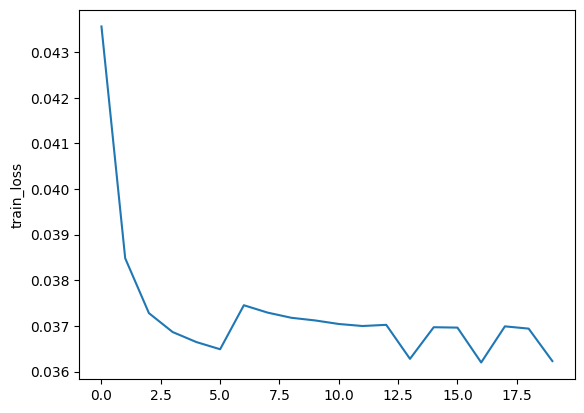

In [12]:
# Training
loss_train = []
for iter in range(args['epochs']):
    loss_locals = []
    w_locals = []
    m = max(int(args['frac'] * args['num_users']), 1)
    idxs_users = np.random.choice(range(args['num_users']), m, replace=False)
    
    for idx in idxs_users:
        local = LocalUpdate(args=args, dataset=dataset_train, indices=dict_users[idx])
        w, loss = local.train(model=copy.deepcopy(net_glob).to(args['gpu']))
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))

    # Update global weights
    w_glob = federated_average(w_locals)

    # Copy weights to net_glob
    net_glob.load_state_dict(w_glob)

    # Print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg))
    loss_train.append(loss_avg)

plt.figure()
plt.plot(range(len(loss_train)), loss_train)
plt.ylabel('train_loss')
plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args['dataset'], args['model'], args['epochs'], args['frac'], args['iid']))

In [13]:
def test_model(net, dataset, args):
    """
    Test the federated model.

    Args:
        net (nn.Module): PyTorch model.
        dataset (TensorDataset): Dataset object containing the testing data.
        args (argparse.Namespace): Object containing the program arguments.

    Returns:
        float: Average loss over the testing dataset.
    """
    net.eval()
    test_loader = DataLoader(dataset, batch_size=args['local_bs'], shuffle=False)
    criterion = nn.MSELoss()
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(args['gpu']), labels.to(args['gpu'])
            outputs, _ = net(images)
            outputs = outputs.view(-1)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

    return test_loss / len(test_loader.dataset)

test_model(net_glob, dataset_test, args)

0.002411589348535528

In [14]:
from sklearn.metrics import mean_absolute_error

def calculate_mae(X_test, y_test, net):
    """
    Calculate the Mean Absolute Error (MAE) for the predictions.

    Args:
        X_test (torch.Tensor): Input features for testing.
        y_test (torch.Tensor): Ground truth labels for testing.
        net (torch.nn.Module): PyTorch model for prediction.

    Returns:
        float: Mean Absolute Error (MAE) between predictions and ground truth labels.
    """
    # Set the model to evaluation mode
    net.eval()

    # Make predictions using the model
    with torch.no_grad():
        outputs, _ = net(X_test)
        predictions = outputs.squeeze().cpu().numpy()

    # Calculate the Mean Absolute Error
    mae = mean_absolute_error(y_test.cpu().numpy(), predictions)

    return mae

calculate_mae(X_test.to(device), y_test.to(device), net_glob)   

0.03606185

In [18]:
import numpy as np
from sklearn.metrics import mean_squared_error

def predict_5min_ahead(model, test_data, device, lags=12):
    # Preprocess test data
    flow_test = test_data[attr].values

    # Prepare input sequences
    input_sequences = []
    for i in range(lags, len(flow_test)):
        input_sequences.append(flow_test[i - lags: i])
    input_sequences = np.array(input_sequences)

    # Convert input sequences to PyTorch tensors and transfer to device
    input_sequences_tensor = torch.from_numpy(input_sequences).float().to(device)

    # Make predictions
    model.eval()
    with torch.no_grad():
        predictions, _ = model(input_sequences_tensor)

    # Calculate MAE
    mae = mean_absolute_error(test_data[attr][lags:], predictions.cpu().numpy().reshape(-1))

    return predictions, mae

# Load the test dataset
test_data = pd.read_csv('/home/girikk/FedGRU/data/test.csv', encoding='utf-8').fillna(0)

# Load the trained model
# Replace 'model' with your actual trained model object
# model = ...

attr = 'Lane 1 Flow (Veh/5 Minutes)'

# Define the device (cuda or cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Make 5-minute ahead predictions and calculate MAE
predictions, mae = predict_5min_ahead(net_glob, test_data, device)

print('Mean Absolute Error (MAE):', mae)


Mean Absolute Error (MAE): 66.62093770852344


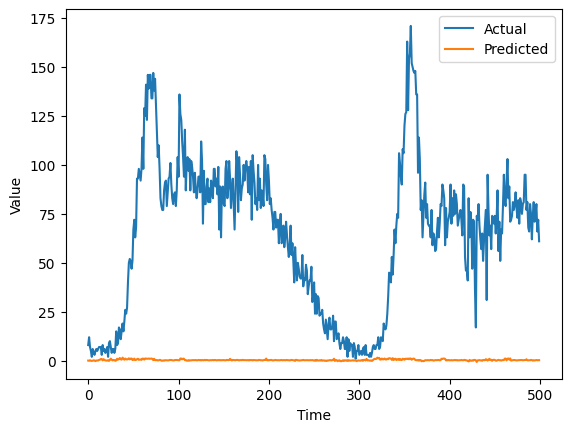

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(predictions, test_data, attr, lags, num_values=None):
    # Convert predictions tensor to NumPy array and reshape if necessary
    predictions = predictions.cpu().numpy().reshape(-1)
    
    # Extract the actual test data
    actual_data = test_data[attr][lags:].values
    
    # Determine the number of values to plot
    if num_values is not None:
        actual_data = actual_data[:num_values]
        predictions = predictions[:num_values]
    
    # Plot the actual data
    plt.plot(actual_data, label='Actual')
    
    # Plot the predicted data
    plt.plot(predictions, label='Predicted')
    
    # Add labels and legend
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    
    # Show plot
    plt.show()

# Example usage with num_values set to 100
plot_predictions(predictions, test_data, attr, 12, num_values=500)
